# Visualization 1d Power Spectrum

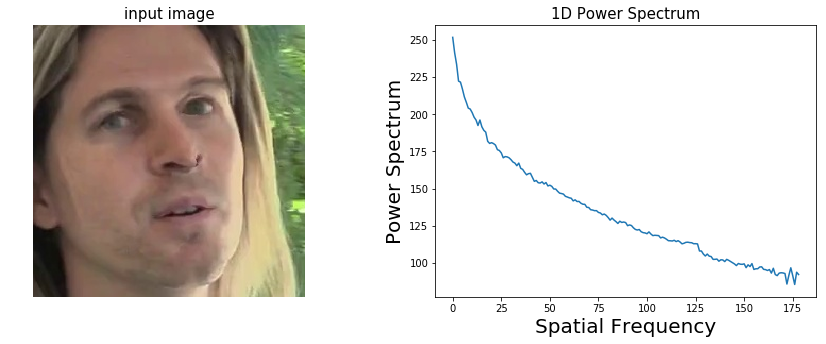

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import radialProfile

epsilon = 1e-8
filename = r'E:\JupyterWorkspace\DFDC\train_pic\fake\aagfhgtpmv.mp4_0.jpg'

img = cv2.imread(filename,0)
img_color = mpimg.imread(filename)
# Calculate FFT
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fshift += epsilon
magnitude_spectrum = 20*np.log(np.abs(fshift))
# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

#Visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
ax.set_title('input image',size=15)
ax2.set_title('1D Power Spectrum',size=15)
plt.xlabel('Spatial Frequency', fontsize=20)
plt.ylabel('Power Spectrum', fontsize=20)
ax.imshow(img_color)
ax2.plot(psd1D)
plt.show()

# Visualization 1d Power Spectrum statistics

ValueError: x and y must have same first dimension, but have shapes (125,) and (179,)

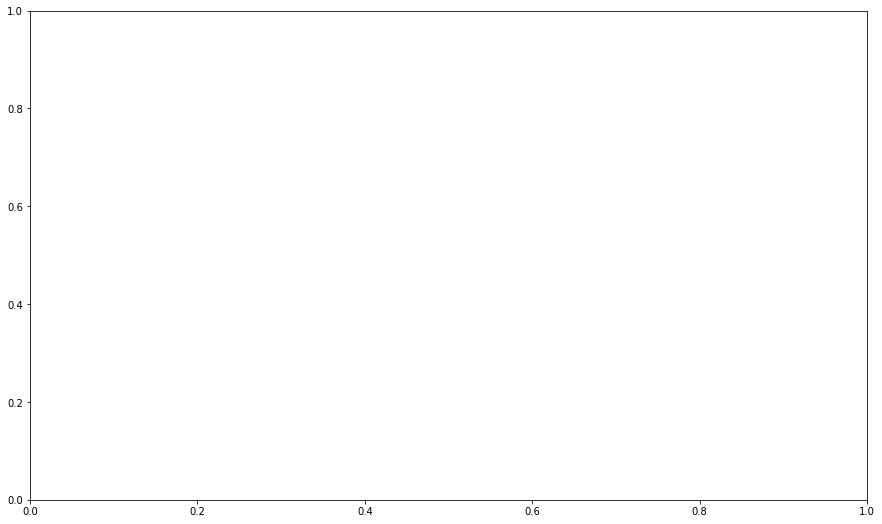

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import radialProfile
import glob

y = []
error = []

path = [r'E:\JupyterWorkspace\DFDC\train_pic\fake\\', r'E:\JupyterWorkspace\DFDC\train_pic\real\\']

for z in range(2):
    # 每个文件中抽取参与测试的图片数
    num_images = 3000
    epsilon = 1e-8
    cont = 0
    psd1D_org = np.zeros((num_images,179))
    psd1D_org_mean = np.zeros(179)
    psd1D_org_std = np.zeros(179)
    

    for filename in glob.glob(path[z]+"*.jpg"):   

        img = cv2.imread(filename,0)
        # 快速傅里叶变换
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        # 计算1D平均功率谱
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

        if cont == num_images:
            break

        psd1D_org[cont,:] = psd1D
        cont +=1

    for x in range(179):
        psd1D_org_mean[x] = np.mean(psd1D_org[:,x])
        psd1D_org_std[x]= np.std(psd1D_org[:,x])

    x = np.arange(0, 179, 1)
    y.append(psd1D_org_mean)
    error.append(psd1D_org_std)

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, y[0], alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, y[0] - error[0], y[0] + error[0], color='red', alpha=0.2)

ax.plot(x, y[1], alpha=0.5, color='blue', label='Real', linewidth = 2.0)
ax.fill_between(x, y[1] - error[1], y[1] + error[1], color='blue', alpha=0.2)

ax.set_title('Satistics 1D Power Spectrum',size=20)
plt.xlabel('Spatial Frequency', fontsize=20)
plt.ylabel('Power Spectrum', fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.show()

# Visualization High-Frequency Components

In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask

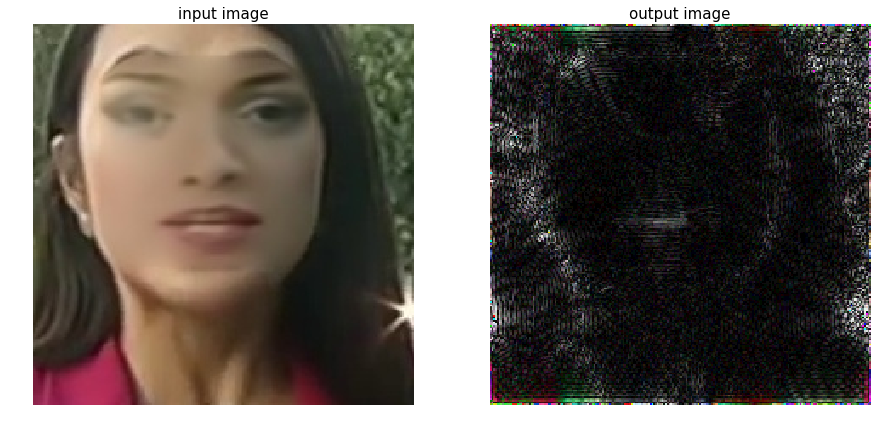

In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import radialProfile
import glob

epsilon = 1e-8
filename = r'E:\JupyterWorkspace\DeepFakeDetection-master\DF\fake_img\001_870_0.jpg'

mask = create_circular_mask(224,224,radius=40)
mask = np.invert(mask)
inv = np.zeros([224,224,3])
img_color =[]

# 读取图片并分离通道
img_color = mpimg.imread(filename)
img_r = img_color[:,:,0]
img_b = img_color[:,:,1]
img_g = img_color[:,:,2]

# Calculate FFT and appply mask for each channel
f_r = np.fft.fft2(img_r)
fshift_r = np.fft.fftshift(f_r)       
fshift_r = fshift_r*mask       
f_ishift_r = np.fft.ifftshift(fshift_r)
img_back_r = np.fft.ifft2(f_ishift_r)
img_back_r = np.abs(img_back_r)

f_b = np.fft.fft2(img_b)
fshift_b = np.fft.fftshift(f_b)
fshift_b = fshift_b*mask   
f_ishift_b = np.fft.ifftshift(fshift_b)
img_back_b = np.fft.ifft2(f_ishift_b)
img_back_b = np.abs(img_back_b)

f_g = np.fft.fft2(img_g)
fshift_g = np.fft.fftshift(f_g)
fshift_g = fshift_g*mask   
f_ishift_g = np.fft.ifftshift(fshift_g)
img_back_g = np.fft.ifft2(f_ishift_g)
img_back_g = np.abs(img_back_g)

inv[:,:,0] = np.round(img_back_r)/255
inv[:,:,1] = np.round(img_back_b)/255
inv[:,:,2] = np.round(img_back_g)/255

# Visualization
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
plt.axis('off')
ax2 = fig.add_subplot(122)
plt.axis('off')

# Weightning for enhance visualization
inv2 = np.copy(inv)
inv2 /= inv.max()
inv2 *= 4

ax.set_title('input image',size=15)
ax.imshow(img_color)
ax2.set_title('output image',size=15)
ax2.imshow(inv2)
plt.show()

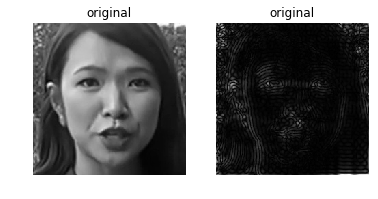

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread(r'E:\JupyterWorkspace\DeepFakeDetection-master\DF\real_img\001_18.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
rows,cols = img.shape
crow,ccol = int(rows/2),int(cols/2)
fshift[crow-20:crow+20,ccol-20:ccol+20]=0
ishift = np.fft.ifftshift(fshift)
iimg = np.fft.ifft2(ishift)
iimg = np.abs(iimg)
plt.subplot(121),plt.imshow(img,cmap='gray')
plt.title('original'),plt.axis('off')
plt.subplot(122),plt.imshow(iimg,cmap='gray')
plt.title('original'),plt.axis('off')
plt.show()